In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv("combined_B_&_C.csv")

In [3]:
print(df.head())

         date      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  2014-05-02   313000.0       3.0       1.50         1340      7912     1.5   
1  2014-05-02  2384000.0       5.0       2.50         3650      9050     2.0   
2  2014-05-02   342000.0       3.0       2.00         1930     11947     1.0   
3  2014-05-02   420000.0       3.0       2.25         2000      8030     1.0   
4  2014-05-02   550000.0       4.0       2.50         1940     10500     1.0   

   waterfront  view  condition  ...  city_grouped_SeaTac  \
0           0     0          3  ...                False   
1           0     4          5  ...                False   
2           0     0          4  ...                False   
3           0     0          4  ...                False   
4           0     0          4  ...                False   

   city_grouped_Seattle  city_grouped_Shoreline  city_grouped_Snoqualmie  \
0                 False                    True                    False   
1     

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9200 entries, 0 to 9199
Data columns (total 79 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           9200 non-null   object 
 1   price                          9200 non-null   float64
 2   bedrooms                       9200 non-null   float64
 3   bathrooms                      9200 non-null   float64
 4   sqft_living                    9200 non-null   int64  
 5   sqft_lot                       9200 non-null   int64  
 6   floors                         9200 non-null   float64
 7   waterfront                     9200 non-null   int64  
 8   view                           9200 non-null   int64  
 9   condition                      9200 non-null   int64  
 10  sqft_above                     9200 non-null   int64  
 11  sqft_basement                  9200 non-null   int64  
 12  yr_built                       9200 non-null   i

In [5]:
# Replace infinite values with NaN in the entire DataFrame
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [6]:
# 3. Define target and features
# We use log_price as the target and remove both 'price' and 'log_price' from the features
target_col = 'log_price'
df.dropna(subset=[target_col], inplace=True)  # ensure no missing target values

In [7]:
# 2. Data Cleaning
# Drop non-numeric columns that are not needed for regression
cols_to_drop = ['date', 'street', 'city', 'statezip', 'country', 'bedrooms_bin', 'bathrooms_bin', 'yr_built_bin', 'sqft_living', 'sqft_above', 'sqft_basement']
df.drop(columns=cols_to_drop, errors='ignore', inplace=True)

In [8]:
# 3. Definefeatures

X = df.drop(columns=['price', 'log_price'], errors='ignore')
y = df[target_col]

In [9]:
if 'yr_renovated_bin' in X.columns:
    X.drop(columns=['yr_renovated_bin'], inplace=True)

In [10]:
# One-hot encode the floors_bin column if it exists (since it has values like '1', '2', '3+')
if 'floors_bin' in df.columns:
    df = pd.get_dummies(df, columns=['floors_bin'], drop_first=True)

In [11]:
# Convert boolean columns to integers (0/1)
df = df.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

In [12]:
# Optional sanity check
print(X.select_dtypes(exclude='number').columns)

Index(['floors_bin', 'city_grouped_Auburn', 'city_grouped_Bellevue',
       'city_grouped_Black Diamond', 'city_grouped_Bothell',
       'city_grouped_Burien', 'city_grouped_Carnation',
       'city_grouped_Clyde Hill', 'city_grouped_Covington',
       'city_grouped_Des Moines', 'city_grouped_Duvall',
       'city_grouped_Enumclaw', 'city_grouped_Fall City',
       'city_grouped_Federal Way', 'city_grouped_Issaquah',
       'city_grouped_Kenmore', 'city_grouped_Kent', 'city_grouped_Kirkland',
       'city_grouped_Lake Forest Park', 'city_grouped_Maple Valley',
       'city_grouped_Medina', 'city_grouped_Mercer Island',
       'city_grouped_Newcastle', 'city_grouped_Normandy Park',
       'city_grouped_North Bend', 'city_grouped_Other', 'city_grouped_Pacific',
       'city_grouped_Ravensdale', 'city_grouped_Redmond',
       'city_grouped_Renton', 'city_grouped_Sammamish', 'city_grouped_SeaTac',
       'city_grouped_Seattle', 'city_grouped_Shoreline',
       'city_grouped_Snoqualmie', 'c

In [13]:
# Just in case, Ensure X contains only numeric columns (drop any remaining non-numeric features)
X = X.select_dtypes(include=[np.number]).copy()

In [14]:
X

,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,yr_built,yr_renovated,yr_after_renovated,...,basement_ratio,sqft_above_ratio,rooms,log_sqft_living,log_sqft_above,log_sqft_basement,zipcode,city_avg_price,zipcode_avg_price,knn_avg_price
0,3.0,1.50,7912,1.5,0,0,3,1955,2005,9,...,0.000000,1.000000,4.50,7.200425,7.200425,0.000000,98133,420392.364047,374433.232975,3.126000e+05
1,5.0,2.50,9050,2.0,0,4,5,1921,0,93,...,0.076712,0.923288,7.50,8.202482,8.122668,5.638355,98119,579837.467282,914441.496599,1.180800e+06
2,3.0,2.00,11947,1.0,0,0,4,1966,0,48,...,0.000000,1.000000,5.00,7.565275,7.565275,0.000000,98042,439492.444648,320243.968571,3.603600e+05
3,3.0,2.25,8030,1.0,0,0,4,1963,0,51,...,0.500000,0.500000,5.25,7.600902,6.907755,6.908755,98008,847180.662995,602963.100000,4.557800e+05
4,4.0,2.50,10500,1.0,0,0,4,1976,1992,22,...,0.412371,0.587629,6.50,7.570443,7.038784,6.685861,98052,667649.534781,637555.719367,4.991200e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9195,3.0,1.75,6360,1.0,0,0,4,1954,1979,35,...,0.000000,1.000000,4.75,7.319865,7.319865,0.000000,98133,579837.467282,374433.232975,3.436333e+05
9196,3.0,2.50,7573,2.0,0,0,3,1983,2009,5,...,0.000000,1.000000,5.50,7.286192,7.286192,0.000000,98007,847180.662995,639103.418803,4.252667e+05
9197,3.0,2.50,7014,2.0,0,0,3,2009,0,5,...,0.000000,1.000000,5.50,8.009695,8.009695,0.000000,98059,377040.966329,499455.770108,4.871408e+05
9198,4.0,2.00,6630,1.0,0,0,3,1974,0,40,...,0.488038,0.511962,6.00,7.644919,6.975414,6.928538,98178,579837.467282,263912.457483,2.194800e+05


In [15]:
# 4. Split the data into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# 5. Setup Cross-Validation and scoring metrics
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
# Using sklearn's built-in scorers for MAE and RMSE.
scoring = {
    'MAE': 'neg_mean_absolute_error', 
    'RMSE': 'neg_root_mean_squared_error'
}

In [17]:
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.api as sm

In [18]:
# Custom wrapper for statsmodels OLS to be used in scikit-learn pipelines
class OLSWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, add_constant=True):
        self.add_constant = add_constant

    def fit(self, X, y):
        # Add intercept if required (statsmodels does not add it automatically)
        if self.add_constant:
            X = sm.add_constant(X)
        self.model_ = sm.OLS(y, X).fit()
        return self

    def predict(self, X):
        if self.add_constant:
            # Make sure we add the constant if needed during prediction
            # 'has_constant' parameter ensures that a constant column isn’t added twice if it already exists.
            X = sm.add_constant(X, has_constant='add')
        return self.model_.predict(X)

    def summary(self):
        return self.model_.summary()

In [19]:
from sklearn.impute import SimpleImputer
# 6. Build Pipelines for the three models

# (Ordinary Linear Regression)
# ols_pipeline = Pipeline([
#    ('imputer', SimpleImputer(strategy='median')),
#    ('scaler', StandardScaler()),
#    ('reg', LinearRegression())
#])

# Baseline: OLS (Ordinary Least Squares) using our custom OLSWrapper
ols_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('reg', OLSWrapper())  # Our custom estimator wrapping statsmodels.OLS
])

# Ridge Regression with built-in cross-validation for alpha tuning
ridge_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('reg', RidgeCV(alphas=[0.01, 0.1, 1, 10, 100], cv=5))
])

# Lasso Regression with built-in cross-validation for alpha tuning
lasso_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('reg', LassoCV(alphas=[0.01, 0.1, 1, 10, 100], cv=5, random_state=42, max_iter=10000))
])

In [20]:
# 7. Evaluation function: performs CV and computes test set errors
def evaluate_model(pipeline, X_train, y_train, X_test, y_test, scoring, cv):
    # Cross-validation on training set
    cv_results = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring, return_train_score=True)
    
    # Fit the pipeline on the full training set
    pipeline.fit(X_train, y_train)
    # Predict on the test set
    y_pred_test = pipeline.predict(X_test)
    
    # Compute test errors
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    # Convert negative scores to positive values
    train_mae = -np.mean(cv_results['train_MAE'])
    train_rmse = -np.mean(cv_results['train_RMSE'])
    cv_mae = -np.mean(cv_results['test_MAE'])
    cv_rmse = -np.mean(cv_results['test_RMSE'])
    
    return {
        'Train MAE': train_mae,
        'Train RMSE': train_rmse,
        'CV MAE': cv_mae,
        'CV RMSE': cv_rmse,
        'Test MAE': test_mae,
        'Test RMSE': test_rmse
    }

In [21]:
# 8. Evaluate each model
results_ols   = evaluate_model(ols_pipeline,   X_train, y_train, X_test, y_test, scoring, cv)
results_ridge = evaluate_model(ridge_pipeline, X_train, y_train, X_test, y_test, scoring, cv)
results_lasso = evaluate_model(lasso_pipeline, X_train, y_train, X_test, y_test, scoring, cv)

In [22]:
# 9. Compile results into a summary table
results_df = pd.DataFrame({
    'Model': ['OLS', 'Ridge', 'Lasso'],
    'Train MAE': [results_ols['Train MAE'], results_ridge['Train MAE'], results_lasso['Train MAE']],
    'CV MAE': [results_ols['CV MAE'], results_ridge['CV MAE'], results_lasso['CV MAE']],
    'Test MAE': [results_ols['Test MAE'], results_ridge['Test MAE'], results_lasso['Test MAE']],
    'Train RMSE': [results_ols['Train RMSE'], results_ridge['Train RMSE'], results_lasso['Train RMSE']],
    'CV RMSE': [results_ols['CV RMSE'], results_ridge['CV RMSE'], results_lasso['CV RMSE']],
    'Test RMSE': [results_ols['Test RMSE'], results_ridge['Test RMSE'], results_lasso['Test RMSE']]
})

print("Model Evaluation Results:\n", results_df)

Model Evaluation Results:
    Model  Train MAE    CV MAE  Test MAE  Train RMSE   CV RMSE  Test RMSE
0    OLS   0.160239  0.164214  0.172749    0.238381  0.361932   0.259917
1  Ridge   0.161232  0.164905  0.173314    0.238990  0.357968   0.259486
2  Lasso   0.209647  0.213785  0.233273    0.291992  0.421131   0.308900


In [23]:
# 10. Save the evaluation table to a CSV file
results_df.to_csv('linear_model_evaluation.csv', index=False)
print("Evaluation results saved to 'linear_model_evaluation.csv'")

Evaluation results saved to 'linear_model_evaluation.csv'


In [24]:
from sklearn.metrics import r2_score

# Predict on the test set for each model using the already fitted pipelines
y_pred_ols   = ols_pipeline.predict(X_test)
y_pred_ridge = ridge_pipeline.predict(X_test)
y_pred_lasso = lasso_pipeline.predict(X_test)

# Calculate R^2 score for each model
r2_ols   = r2_score(y_test, y_pred_ols)
r2_ridge = r2_score(y_test, y_pred_ridge)
r2_lasso = r2_score(y_test, y_pred_lasso)

# Print the previously calculated evaluation metrics along with the R^2 score
print("Detailed Model Evaluation Results:")
print("OLS Results:")
print(f"  Train MAE: {results_ols['Train MAE']:.4f}")
print(f"  Train RMSE: {results_ols['Train RMSE']:.4f}")
print(f"  CV MAE: {results_ols['CV MAE']:.4f}")
print(f"  CV RMSE: {results_ols['CV RMSE']:.4f}")
print(f"  Test MAE: {results_ols['Test MAE']:.4f}")
print(f"  Test RMSE: {results_ols['Test RMSE']:.4f}")
print(f"  Test R^2: {r2_ols:.4f}\n")

print("Ridge Results:")
print(f"  Train MAE: {results_ridge['Train MAE']:.4f}")
print(f"  Train RMSE: {results_ridge['Train RMSE']:.4f}")
print(f"  CV MAE: {results_ridge['CV MAE']:.4f}")
print(f"  CV RMSE: {results_ridge['CV RMSE']:.4f}")
print(f"  Test MAE: {results_ridge['Test MAE']:.4f}")
print(f"  Test RMSE: {results_ridge['Test RMSE']:.4f}")
print(f"  Test R^2: {r2_ridge:.4f}\n")

print("Lasso Results:")
print(f"  Train MAE: {results_lasso['Train MAE']:.4f}")
print(f"  Train RMSE: {results_lasso['Train RMSE']:.4f}")
print(f"  CV MAE: {results_lasso['CV MAE']:.4f}")
print(f"  CV RMSE: {results_lasso['CV RMSE']:.4f}")
print(f"  Test MAE: {results_lasso['Test MAE']:.4f}")
print(f"  Test RMSE: {results_lasso['Test RMSE']:.4f}")
print(f"  Test R^2: {r2_lasso:.4f}")


Detailed Model Evaluation Results:
OLS Results:
  Train MAE: 0.1602
  Train RMSE: 0.2384
  CV MAE: 0.1642
  CV RMSE: 0.3619
  Test MAE: 0.1727
  Test RMSE: 0.2599
  Test R^2: 0.7611

Ridge Results:
  Train MAE: 0.1612
  Train RMSE: 0.2390
  CV MAE: 0.1649
  CV RMSE: 0.3580
  Test MAE: 0.1733
  Test RMSE: 0.2595
  Test R^2: 0.7619

Lasso Results:
  Train MAE: 0.2096
  Train RMSE: 0.2920
  CV MAE: 0.2138
  CV RMSE: 0.4211
  Test MAE: 0.2333
  Test RMSE: 0.3089
  Test R^2: 0.6625


In [25]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9102 entries, 0 to 9199
Data columns (total 69 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   price                          9102 non-null   float64
 1   bedrooms                       9102 non-null   float64
 2   bathrooms                      9102 non-null   float64
 3   sqft_lot                       9102 non-null   int64  
 4   floors                         9102 non-null   float64
 5   waterfront                     9102 non-null   int64  
 6   view                           9102 non-null   int64  
 7   condition                      9102 non-null   int64  
 8   yr_built                       9102 non-null   int64  
 9   yr_renovated                   9102 non-null   int64  
 10  log_price                      9102 non-null   float64
 11  yr_after_renovated             9102 non-null   int64  
 12  yr_after_built                 9102 non-null   int64 

In [26]:
# Fit the pipeline on your training data
ols_pipeline.fit(X_train, y_train)

# Access the statsmodels OLS results via the custom wrapper
ols_results = ols_pipeline.named_steps['reg']

# Print the full regression output
print(ols_results.summary())


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     1279.
Date:                Wed, 16 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:51:44   Log-Likelihood:                -149.61
No. Observations:                7281   AIC:                             345.2
Df Residuals:                    7258   BIC:                             503.8
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0661      0.003   4506.805      0.0

In [27]:
# Fit the ridge pipeline on my training data
ridge_pipeline.fit(X_train, y_train)

# Access the trained ridge regressor from the pipeline
ridge_reg = ridge_pipeline.named_steps['reg']

# Retrieve coefficients and intercept
ridge_coef = ridge_reg.coef_
ridge_intercept = ridge_reg.intercept_

# Create a summary table with feature names
# Get feature names from X_train (assumes X_train is a DataFrame)
features = X_train.columns
ridge_summary = pd.DataFrame({
    'Feature': ['Intercept'] + list(features),
    'Coefficient': [ridge_intercept] + list(ridge_coef)
})

print("Ridge Regression Summary:")
print(ridge_summary)


Ridge Regression Summary:
               Feature  Coefficient
0            Intercept    13.066131
1             bedrooms    -0.033703
2            bathrooms     0.041230
3             sqft_lot     0.004708
4               floors     0.036089
5           waterfront     0.011052
6                 view     0.045268
7            condition     0.030034
8             yr_built    -0.020480
9         yr_renovated    -0.000526
10  yr_after_renovated    -0.006805
11      yr_after_built     0.020480
12      price_per_sqft     0.120300
13    basement_present     0.039438
14        if_renovated     0.006613
15       if_waterfront     0.011052
16      basement_ratio     0.022949
17    sqft_above_ratio    -0.004753
18               rooms     0.001178
19     log_sqft_living     0.144977
20      log_sqft_above     0.135275
21   log_sqft_basement    -0.013919
22             zipcode     0.043058
23      city_avg_price     0.075589
24   zipcode_avg_price     0.159842
25       knn_avg_price     0.034454


In [28]:
# Fit the lasso pipeline on my training data
lasso_pipeline.fit(X_train, y_train)

# Access the trained lasso regressor from the pipeline
lasso_reg = lasso_pipeline.named_steps['reg']

# Retrieve coefficients and intercept
lasso_coef = lasso_reg.coef_
lasso_intercept = lasso_reg.intercept_

# Create a summary table with feature names
features = X_train.columns
lasso_summary = pd.DataFrame({
    'Feature': ['Intercept'] + list(features),
    'Coefficient': [lasso_intercept] + list(lasso_coef)
})

print("Lasso Regression Summary:")
print(lasso_summary)


Lasso Regression Summary:
               Feature  Coefficient
0            Intercept    13.066131
1             bedrooms     0.000000
2            bathrooms     0.000000
3             sqft_lot     0.000000
4               floors     0.000000
5           waterfront     0.000000
6                 view     0.000000
7            condition     0.000000
8             yr_built    -0.000000
9         yr_renovated    -0.000000
10  yr_after_renovated     0.000000
11      yr_after_built     0.000000
12      price_per_sqft     0.032557
13    basement_present     0.000000
14        if_renovated    -0.000000
15       if_waterfront     0.000000
16      basement_ratio     0.000000
17    sqft_above_ratio    -0.000000
18               rooms     0.000000
19     log_sqft_living     0.182775
20      log_sqft_above     0.000000
21   log_sqft_basement     0.000000
22             zipcode     0.000000
23      city_avg_price     0.001875
24   zipcode_avg_price     0.165406
25       knn_avg_price     0.062225


In [29]:
# Extract OLS coefficients with sign (excluding intercept)
ols_model = ols_pipeline.named_steps['reg'].model_
ols_coef = pd.Series(ols_model.params[1:], index=ols_model.model.exog_names[1:])  # exclude intercept
ols_top5 = ols_coef.abs().sort_values(ascending=False).head(5)

# Print top 5 with actual signed values
print("OLS Top 5 Features with Coefficients:")
print(ols_coef.loc[ols_top5.index])


OLS Top 5 Features with Coefficients:
x9    -1.153135
x14    1.151203
x21   -0.186984
x13    0.175417
x24    0.162773
dtype: float64


In [30]:
# Extract Ridge coefficients
ridge_coef = pd.Series(ridge_pipeline.named_steps['reg'].coef_, index=X_train.columns)
ridge_top5 = ridge_coef.abs().sort_values(ascending=False).head(5)

# Print top 5 with actual signed values
print("Ridge Top 5 Features with Coefficients:")
print(ridge_coef.loc[ridge_top5.index])


Ridge Top 5 Features with Coefficients:
zipcode_avg_price    0.159842
log_sqft_living      0.144977
log_sqft_above       0.135275
price_per_sqft       0.120300
city_avg_price       0.075589
dtype: float64


In [31]:
# Extract Lasso coefficients
lasso_coef = pd.Series(lasso_pipeline.named_steps['reg'].coef_, index=X_train.columns)
lasso_top5 = lasso_coef.abs().sort_values(ascending=False).head(5)

# Print top 5 with actual signed values
print("Lasso Top 5 Features with Coefficients:")
print(lasso_coef.loc[lasso_top5.index])


Lasso Top 5 Features with Coefficients:
log_sqft_living      0.182775
zipcode_avg_price    0.165406
knn_avg_price        0.062225
price_per_sqft       0.032557
city_avg_price       0.001875
dtype: float64


In [32]:
from sklearn.metrics import r2_score

# Predict on test set
lasso_preds = lasso_pipeline.predict(X_test)
ridge_preds = ridge_pipeline.predict(X_test)

# Calculate R^2 scores
lasso_r2 = r2_score(y_test, lasso_preds)
ridge_r2 = r2_score(y_test, ridge_preds)

lasso_r2, ridge_r2


(0.6625491773906349, 0.7618752724144198)

In [33]:
from sklearn.metrics import mean_absolute_percentage_error

ols_preds = ols_pipeline.predict(X_test)
ridge_preds = ridge_pipeline.predict(X_test)
lasso_preds = lasso_pipeline.predict(X_test)

ols_mape = mean_absolute_percentage_error(y_test, ols_preds)
ridge_mape = mean_absolute_percentage_error(y_test, ridge_preds)
lasso_mape = mean_absolute_percentage_error(y_test, lasso_preds)

print(f"OLS MAPE: {ols_mape:.4f}")
print(f"Ridge MAPE: {ridge_mape:.4f}")
print(f"Lasso MAPE: {lasso_mape:.4f}")

OLS MAPE: 0.0133
Ridge MAPE: 0.0133
Lasso MAPE: 0.0179


# XGBoost

In [34]:
data = pd.read_csv("cleaned_house_dataset.csv")

# Drop irrelevant or categorical columns before modeling
data.drop(columns=['date', 'street', 'city', 'statezip', 'country','yr_built','yr_renovated'], inplace=True)

# Drop rows where price is zero
data = data[data['price'] > 0].copy()

In [35]:
# Define features and target for XGBoost
X_xgb = data.drop(columns=['price'])
y_xgb = data['price']

# Split into training and test sets
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, test_size=0.2, random_state=42
)

In [36]:
# import XGBoost and RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Hyperparameter search space
param_dist = {
    'n_estimators': randint(200, 600),     
    'max_depth': randint(4, 12),              
    'learning_rate': uniform(0.01, 0.15),     
    'subsample': uniform(0.6, 0.4),          
    'colsample_bytree': uniform(0.6, 0.4),   
    'reg_alpha': uniform(0, 0.5),          
    'reg_lambda': uniform(0.5, 1)   
}


# Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='r2',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit model
random_search.fit(X_train_xgb, y_train_xgb)

# Get best model and parameters
best_xgb_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'colsample_bytree': 0.6835674870461441, 'learning_rate': 0.11067152752360758, 'max_depth': 10, 'n_estimators': 326, 'reg_alpha': 0.25916482618186837, 'reg_lambda': 1.3773730719279556, 'subsample': 0.8963074471016818}


In [37]:
# Train final XGBoost model with best hyperparameters
final_xgb_model = XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.6835674870461441,
    learning_rate=0.11067152752360758,
    max_depth=10,
    n_estimators=326,
    reg_alpha=0.92591,
    reg_lambda=1.37737,
    subsample=0.8963,
    random_state=42
)

final_xgb_model.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6835674870461441, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.11067152752360758, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=326, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Predict on test set
y_pred_xgb = final_xgb_model.predict(X_test_xgb)

# Evaluate metrics
mae = mean_absolute_error(y_test_xgb, y_pred_xgb)
rmse = mean_squared_error(y_test_xgb, y_pred_xgb, squared=False)
mape = mean_absolute_percentage_error(y_test_xgb, y_pred_xgb)

# Get feature importances
importances = pd.Series(final_xgb_model.feature_importances_, index=X_train_xgb.columns)
top5_features = importances.sort_values(ascending=False).head(5)

top5_features

d:\Python\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


waterfront     0.329643
condition      0.126880
sqft_above     0.121389
sqft_living    0.073791
bathrooms      0.070444
dtype: float32

In [40]:
mae, rmse, mape

(50871.75613556617, 207685.86969964253, 0.13087430328553135)

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np

y_train_pred = final_xgb_model.predict(X_train_xgb)

mae_train = mean_absolute_error(y_train_xgb, y_train_pred)
rmse_train = mean_squared_error(y_train_xgb, y_train_pred, squared=False)
mape_train = mean_absolute_percentage_error(y_train_xgb, y_train_pred)

y_test_pred = final_xgb_model.predict(X_test_xgb)

mae_test = mean_absolute_error(y_test_xgb, y_test_pred)
rmse_test = mean_squared_error(y_test_xgb, y_test_pred, squared=False)
mape_test = mean_absolute_percentage_error(y_test_xgb, y_test_pred)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_cv_pred = cross_val_predict(final_xgb_model, X_xgb, y_xgb, cv=kf, n_jobs=-1)

mae_cv = mean_absolute_error(y_xgb, y_cv_pred)
rmse_cv = mean_squared_error(y_xgb, y_cv_pred, squared=False)
mape_cv = mean_absolute_percentage_error(y_xgb, y_cv_pred)

print("Train Set:")
print(f"MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}, MAPE: {mape_train:.4f}")

print("Test Set:")
print(f"MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}, MAPE: {mape_test:.4f}")

print("Cross-Validation:")
print(f"MAE: {mae_cv:.2f}, RMSE: {rmse_cv:.2f}, MAPE: {mape_cv:.4f}")


d:\Python\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train Set:
MAE: 11030.23, RMSE: 18236.00, MAPE: 0.0291
Test Set:
MAE: 50871.76, RMSE: 207685.87, MAPE: 0.1309
Cross-Validation:
MAE: 52787.37, RMSE: 175884.81, MAPE: 0.1216


d:\Python\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [42]:
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

r2_test = r2_score(y_test_xgb, y_test_pred)

print("Test R²:", round(r2_test, 4))

Test R²: 0.9104


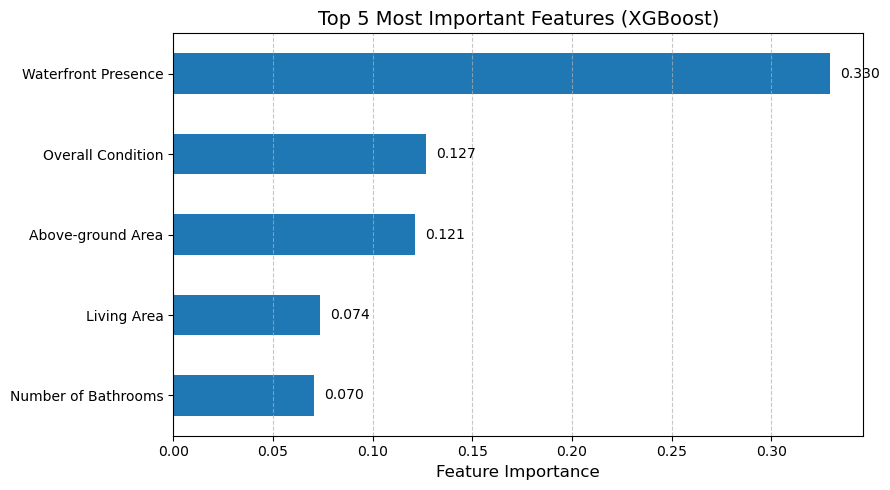

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

feature_name_map = {
    'waterfront': 'Waterfront Presence',
    'condition': 'Overall Condition',
    'sqft_above': 'Above-ground Area',
    'sqft_living': 'Living Area',
    'bathrooms': 'Number of Bathrooms'
}

raw_top5 = pd.Series({
    'waterfront': 0.329643,
    'condition': 0.126880,
    'sqft_above': 0.121389,
    'sqft_living': 0.073791,
    'bathrooms': 0.070444
})
top5_features = raw_top5.rename(index=feature_name_map)

plt.figure(figsize=(9, 5))
ax = top5_features.sort_values().plot(kind='barh', color=["#1f77b4"])

for i, value in enumerate(top5_features.sort_values()):
    plt.text(value + 0.005, i, f"{value:.3f}", va='center')

plt.xlabel("Feature Importance", fontsize=12)
plt.title("Top 5 Most Important Features (XGBoost)", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Comparison

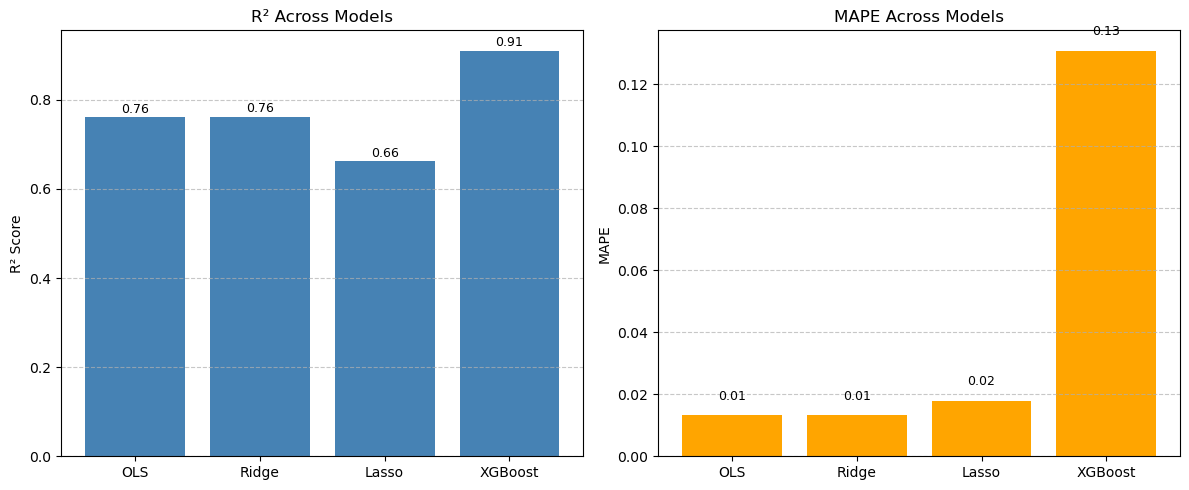

In [45]:
# Plot R² and MAPE in two separate bar charts with only two colors
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Define colors
color_r2 = 'steelblue'
color_mape = 'orange'

# Define scores
scores = {
    'OLS': [r2_ols, ols_mape],
    'Ridge': [r2_ridge, ridge_mape],
    'Lasso': [r2_lasso, lasso_mape],
    'XGBoost': [r2_test, mape_test]
}

# Model names
model_names = list(scores.keys())

# R² bar plot
r2_values = [scores[model][0] for model in model_names]
axes[0].bar(model_names, r2_values, color=color_r2)
for i, v in enumerate(r2_values):
    axes[0].text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=9)
axes[0].set_title("R² Across Models")
axes[0].set_ylabel("R² Score")
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# MAPE bar plot
mape_values = [scores[model][1] for model in model_names]
axes[1].bar(model_names, mape_values, color=color_mape)
for i, v in enumerate(mape_values):
    axes[1].text(i, v + 0.005, f"{v:.2f}", ha='center', fontsize=9)
axes[1].set_title("MAPE Across Models")
axes[1].set_ylabel("MAPE")
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


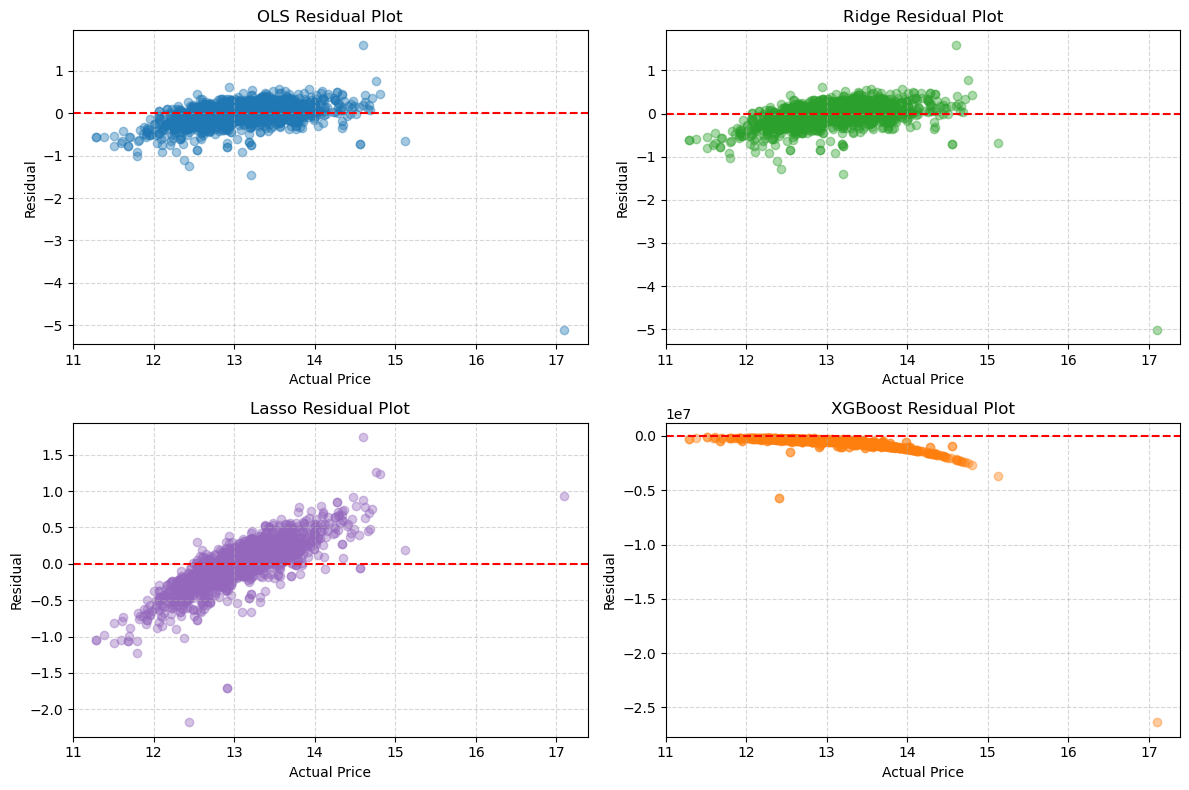

In [46]:
import matplotlib.pyplot as plt

colors = {
    'OLS': '#1f77b4',     
    'Ridge': '#2ca02c',    
    'Lasso': '#9467bd',    
    'XGBoost': '#ff7f0e'   
}

residuals = {
    'OLS': y_test - ols_preds,
    'Ridge': y_test - ridge_preds,
    'Lasso': y_test - lasso_preds,
    'XGBoost': y_test - y_pred_xgb
}

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, (model, res) in enumerate(residuals.items()):
    ax = axes[i // 2, i % 2]
    ax.scatter(y_test, res, alpha=0.4, color=colors[model])
    ax.axhline(0, color='red', linestyle='--')
    ax.set_title(f"{model} Residual Plot")
    ax.set_xlabel("Actual Price")
    ax.set_ylabel("Residual")
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


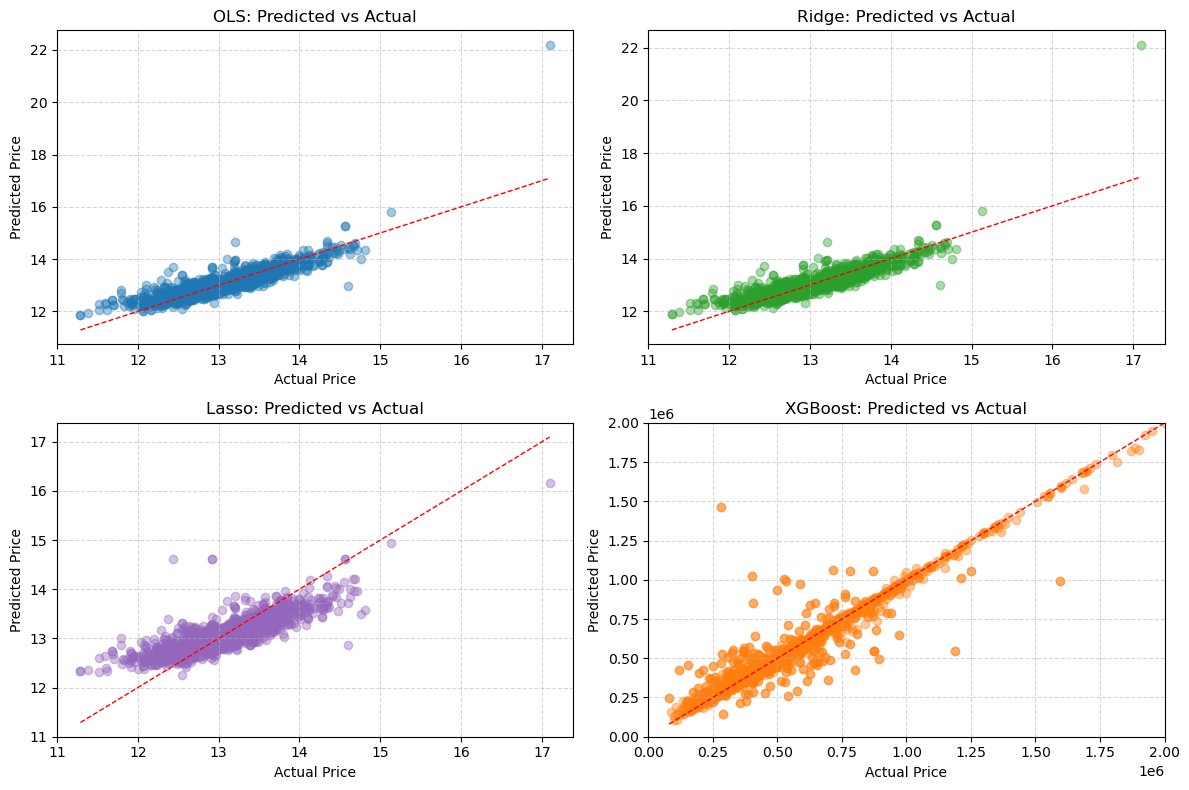

In [47]:
import matplotlib.pyplot as plt

colors = {
    'OLS': '#1f77b4',
    'Ridge': '#2ca02c',
    'Lasso': '#9467bd',
    'XGBoost': '#ff7f0e'
}

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

predictions = {
    'OLS': (y_test, ols_preds),
    'Ridge': (y_test, ridge_preds),
    'Lasso': (y_test, lasso_preds),
    'XGBoost': (y_test_xgb, y_pred_xgb)
}

for i, (model, (actual, pred)) in enumerate(predictions.items()):
    ax = axes[i // 2, i % 2]
    ax.scatter(actual, pred, alpha=0.4, color=colors[model])
    ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', linewidth=1)
    ax.set_title(f"{model}: Predicted vs Actual")
    ax.set_xlabel("Actual Price")
    ax.set_ylabel("Predicted Price")
    ax.grid(True, linestyle='--', alpha=0.5)

    if model == 'XGBoost':
        ax.set_xlim(0, 2e6)
        ax.set_ylim(0, 2e6)

plt.tight_layout()
plt.show()


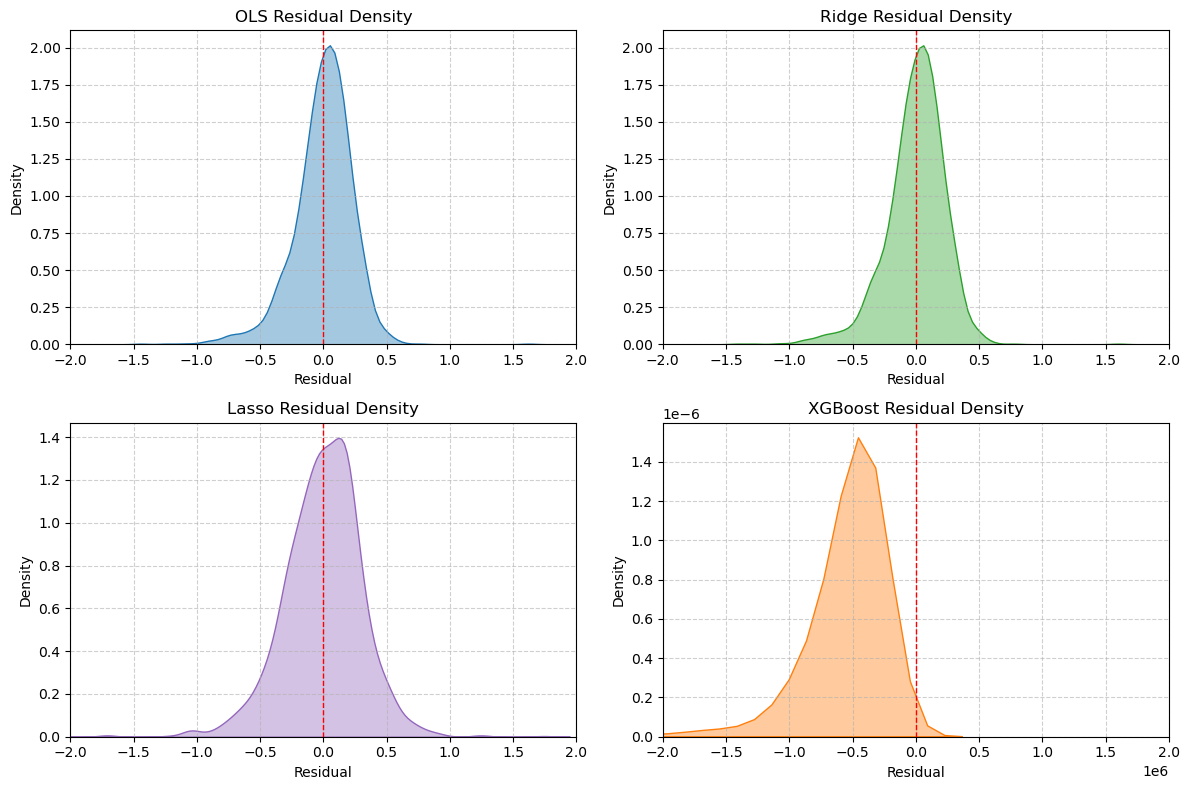

In [48]:
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np


colors = {
    'OLS': '#1f77b4',    
    'Ridge': '#2ca02c',  
    'Lasso': '#9467bd',  
    'XGBoost': '#ff7f0e'  
}

cleaned_residuals = {}
for model, res in residuals.items():
    res = np.array(res)
    cleaned = res[np.isfinite(res)]
    cleaned_residuals[model] = cleaned

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, (model, res) in enumerate(cleaned_residuals.items()):
    ax = axes[i // 2, i % 2]
    sns.kdeplot(x=res, ax=ax, fill=True, color=colors[model], alpha=0.4)
    ax.axvline(0, color='red', linestyle='--', linewidth=1)

    if model == 'XGBoost':
        ax.set_xlim(-2e6, 2e6)
    else:
        ax.set_xlim(-2, 2)

    ax.set_title(f"{model} Residual Density")
    ax.set_xlabel("Residual")
    ax.set_ylabel("Density")
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


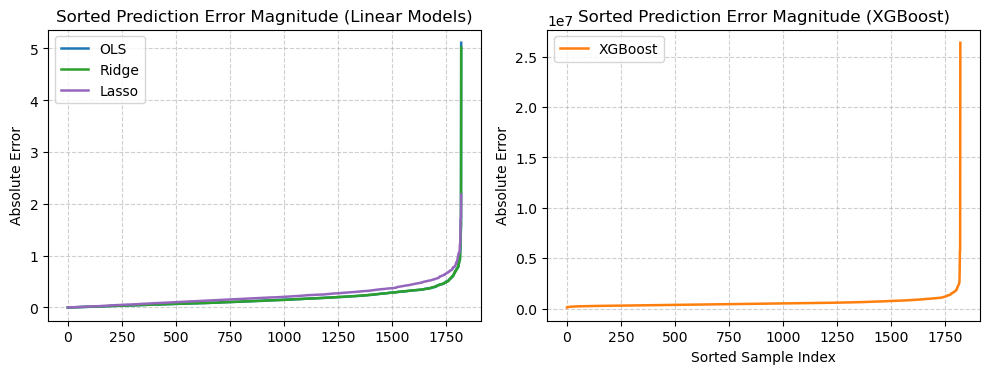

In [49]:
import matplotlib.pyplot as plt
import numpy as np

abs_errors_sorted = {
    model: np.sort(np.abs(residuals[model]))
    for model in ['OLS', 'Ridge', 'Lasso', 'XGBoost']
}

# 配色
colors = {
    'OLS': '#1f77b4',
    'Ridge': '#2ca02c',
    'Lasso': '#9467bd',
    'XGBoost': '#ff7f0e'
}

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=False)

for model in ['OLS', 'Ridge', 'Lasso']:
    axes[0].plot(abs_errors_sorted[model], label=model, color=colors[model], linewidth=1.8)
axes[0].set_title("Sorted Prediction Error Magnitude (Linear Models)")
axes[0].set_ylabel("Absolute Error")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

axes[1].plot(abs_errors_sorted['XGBoost'], label='XGBoost', color=colors['XGBoost'], linewidth=1.8)
axes[1].set_title("Sorted Prediction Error Magnitude (XGBoost)")
axes[1].set_xlabel("Sorted Sample Index")
axes[1].set_ylabel("Absolute Error")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
